### Understanding RFMS

- ##### Recency (R): How recently a customer has made a transaction.
- ##### Frequency (F): How often a customer makes transactions.
- ##### Monetary (M): The monetary value of transactions made by the customer.
- ##### Score (S): Could be a summary score based on R, F, and M, often calculated in ways relevant to the business context.


## Constructing a Default Estimator (Proxy)

#### Calculate RFMS Components:

### imports

In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

In [ ]:


# Load your data
df = pd.read_csv('../data/data.csv')  # Replace with your actual file path


# Convert 'TransactionStartTime' to datetime if not already done
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Recency - Days since last transaction
df['TransactionDate'] = df['TransactionStartTime'].dt.date  # Convert to date for grouping
max_date = df['TransactionStartTime'].max().date()  # Ensure max_date is a date
df['Recency'] = (df['TransactionStartTime'].max() - df.groupby('AccountId')['TransactionStartTime'].transform('max')).dt.days

# Frequency - Number of transactions
df['Frequency'] = df.groupby('AccountId')['TransactionId'].transform('count')

# Monetary - Total amount spent
df['Monetary'] = df.groupby('AccountId')['Amount'].transform('sum')

# Score - Here we can use a simple sum, but in practice, you might use a weighted score
df['Score'] = df['Recency'] + df['Frequency'] + df['Monetary']  # Example of scoring, adjust as needed

# Display the first few rows to verify new features
print(df[['AccountId', 'Recency', 'Frequency', 'Monetary', 'Score']].head())

        AccountId  Recency  Frequency    Monetary       Score
0  AccountId_3957        5         66    156884.0    156955.0
1  AccountId_4841        0      30893 -27750277.5 -27719384.5
2  AccountId_4229       81          2      1000.0      1083.0
3   AccountId_648        5         26    251000.0    251031.0
4  AccountId_4841        0      30893 -27750277.5 -27719384.5


#### Visualize RFMS Space:

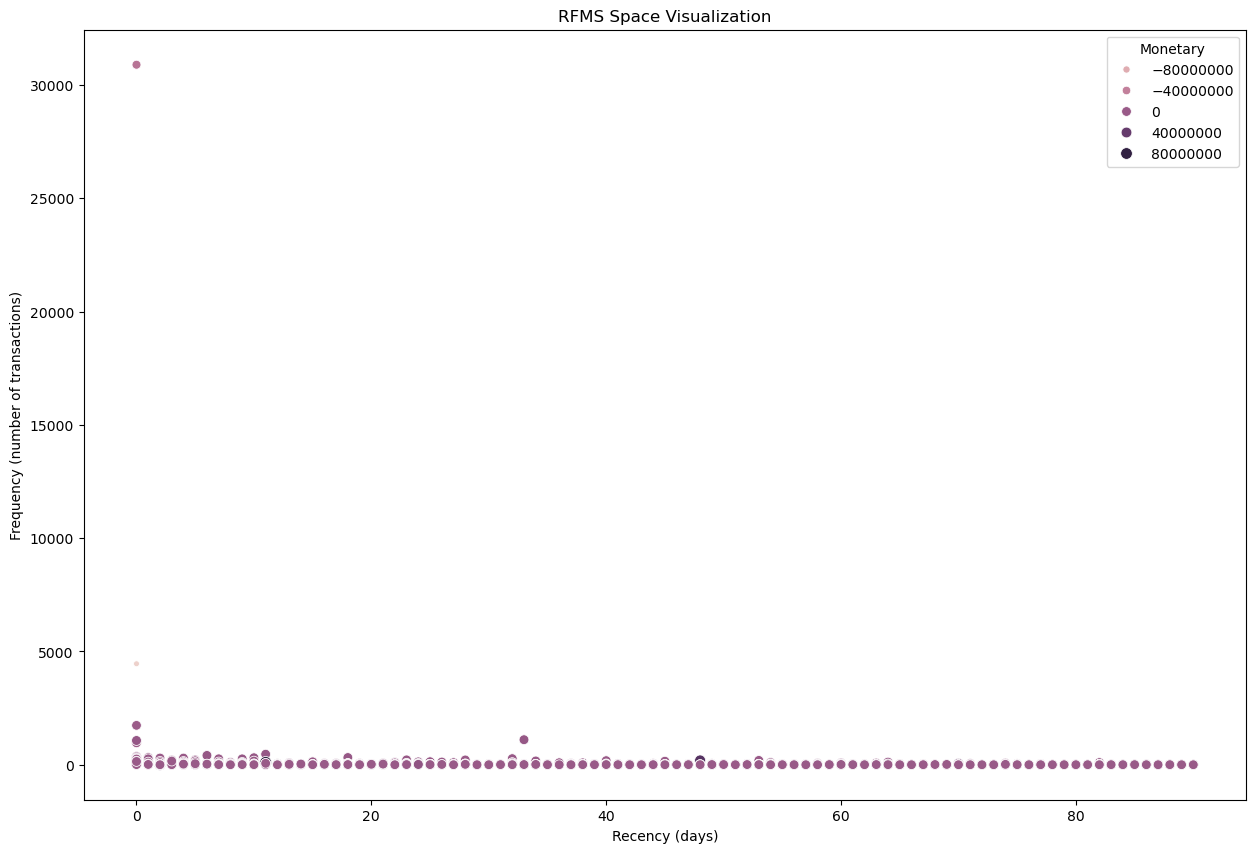

In [6]:


# Visualize to see natural clustering or boundaries
plt.figure(figsize=(15, 10))

# Example: Scatter plot of Recency vs Frequency colored by Monetary value
sns.scatterplot(x='Recency', y='Frequency', size='Monetary', hue='Monetary', data=df.groupby('AccountId').first())
plt.title('RFMS Space Visualization')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (number of transactions)')
plt.show()

# You might want to look at different combinations or use 3D plots for better insight

### Establish a Boundary for Classification:

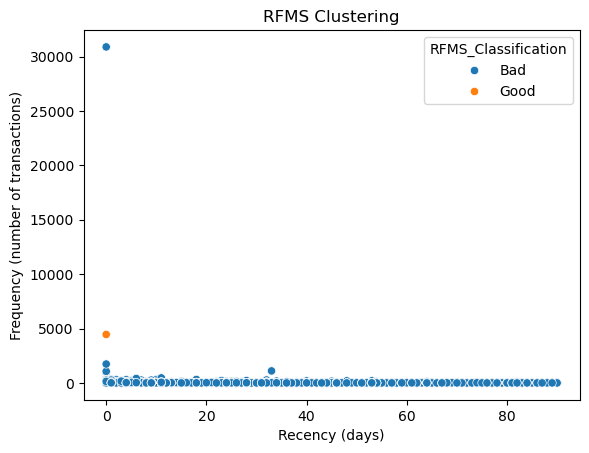

In [7]:


# Fit KMeans clustering to find groups
kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['Recency', 'Frequency', 'Monetary']])
df['RFMS_Cluster'] = kmeans.labels_

# Assuming cluster 0 is bad and cluster 1 is good, adjust based on your observation
df['RFMS_Classification'] = df['RFMS_Cluster'].map({0: 'Bad', 1: 'Good'})

# Visualize the clusters
sns.scatterplot(x='Recency', y='Frequency', hue='RFMS_Classification', data=df.groupby('AccountId').first())
plt.title('RFMS Clustering')
plt.xlabel('Recency (days)')
plt.ylabel('Frequency (number of transactions)')
plt.show()

## WoE Binning

        WOE        IV
2  6.894012  0.216382
0 -0.527706  0.216382
4  6.694177  0.216382
3  6.905146  0.216382
1  6.761216  0.216382


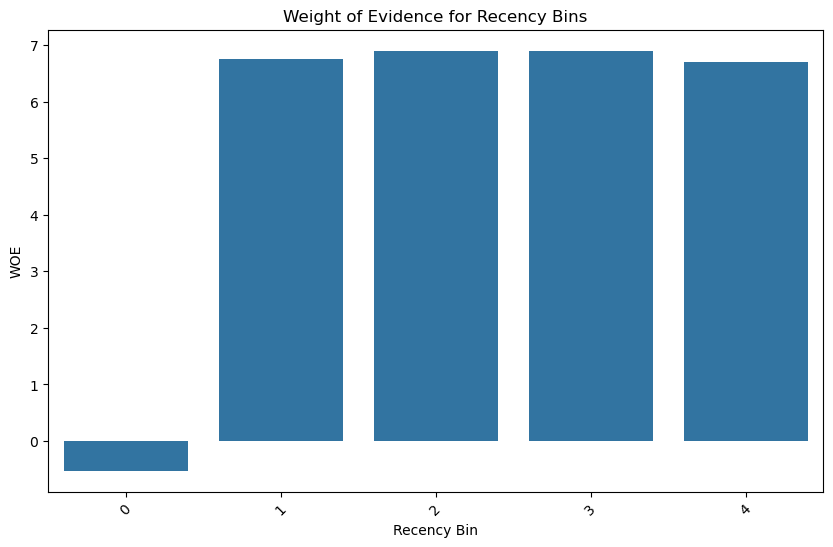

Information Value for Recency: 0.21638237590441392


In [14]:


def woe_iv(X, y, event=1):
    d1 = pd.DataFrame({'X': X, 'Y': y})
    n = d1.shape[0]
    good = (d1['Y'] == event).sum()
    bad = n - good
    g = d1[d1['Y'] == event].groupby('X').size().reindex(X.unique(), fill_value=0.5)  # Add small value to avoid div by zero
    b = d1[d1['Y'] != event].groupby('X').size().reindex(X.unique(), fill_value=0.5)
    
    categories = X.unique()
    g1 = g.values
    b1 = b.values

    woe = np.log((g1 / good) / (b1 / bad))
    
    # Calculate IV only for non-zero categories to avoid infinite values
    non_zero_categories = (g1 != 0.5) & (b1 != 0.5)  # Assuming 0.5 is the fill value for zero counts
    iv = ((g[non_zero_categories] / good - b[non_zero_categories] / bad) * woe[non_zero_categories]).sum()
    
    df = pd.DataFrame({'WOE': woe, 'IV': iv}, index=categories)
    return df

# Assuming 'df' is your DataFrame after RFMS calculation
# Bin 'Recency' into 10 quantile bins, dropping duplicate bin edges
df['Recency_Bin'] = pd.qcut(df['Recency'], q=10, labels=False, duplicates='drop')

# Example usage for 'Recency_Bin'
X = df['Recency_Bin']
y = (df['RFMS_Classification'] == 'Bad').astype(int)  # 1 for Bad, 0 for Good

woe_df = woe_iv(X, y)
print(woe_df)

# Visualize WOE for better understanding
plt.figure(figsize=(10, 6))
sns.barplot(x=woe_df.index, y=woe_df['WOE'])
plt.title('Weight of Evidence for Recency Bins')
plt.xlabel('Recency Bin')
plt.ylabel('WOE')
plt.xticks(rotation=45)
plt.show()

# Add WOE as a feature to your DataFrame
df = df.merge(woe_df['WOE'], left_on='Recency_Bin', right_index=True, how='left', suffixes=('', '_WOE'))
df.rename(columns={'WOE': 'Recency_WOE'}, inplace=True)

# Print IV for the feature
print(f"Information Value for Recency: {woe_df['IV'].iloc[0]}")